In [1]:
import os
os.chdir("../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [4]:
import glob
images = glob.glob("data/rsna-bone-age/training/preprocessed_discarded/*.png")
image_ids = [os.path.basename(img).split(".")[0] for img in images]

for id_ in image_ids:
    image = cv2.imread("data/rsna-bone-age/training/boneage-training-dataset/" + id_ + ".png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cursed_image = cv2.imread("data/rsna-bone-age/training/preprocessed_discarded/" + id_ + ".png")
    break

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

NameError: name 'image' is not defined

<Figure size 1000x1000 with 0 Axes>

In [6]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "output/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [7]:
predictor.set_image(image)

In [8]:
input_point = np.array([[image.shape[1]/2 + 80, image.shape[0]/2 + 150]])
input_label = np.array([1])

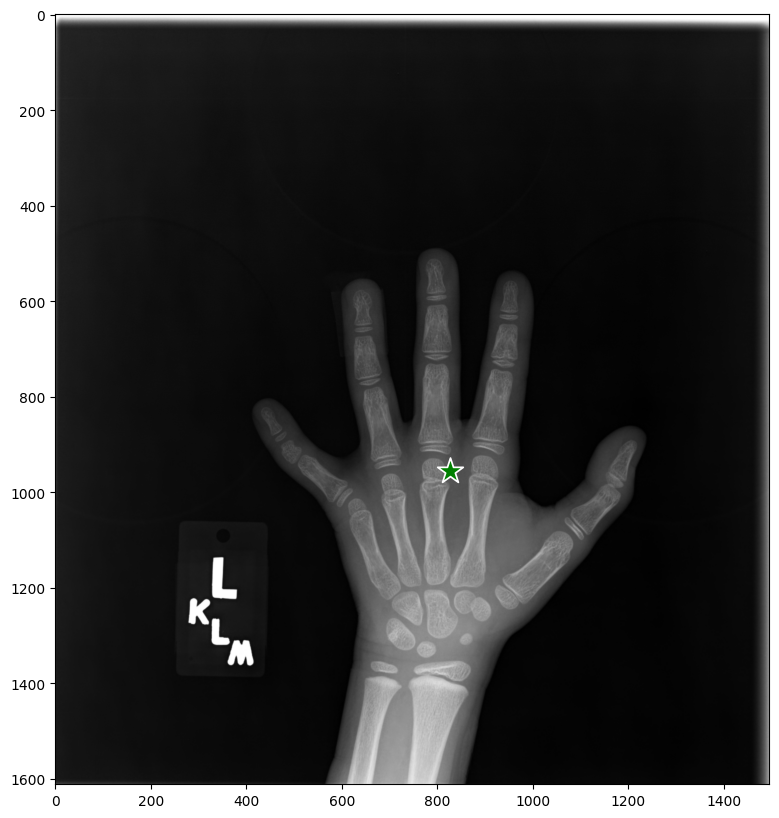

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

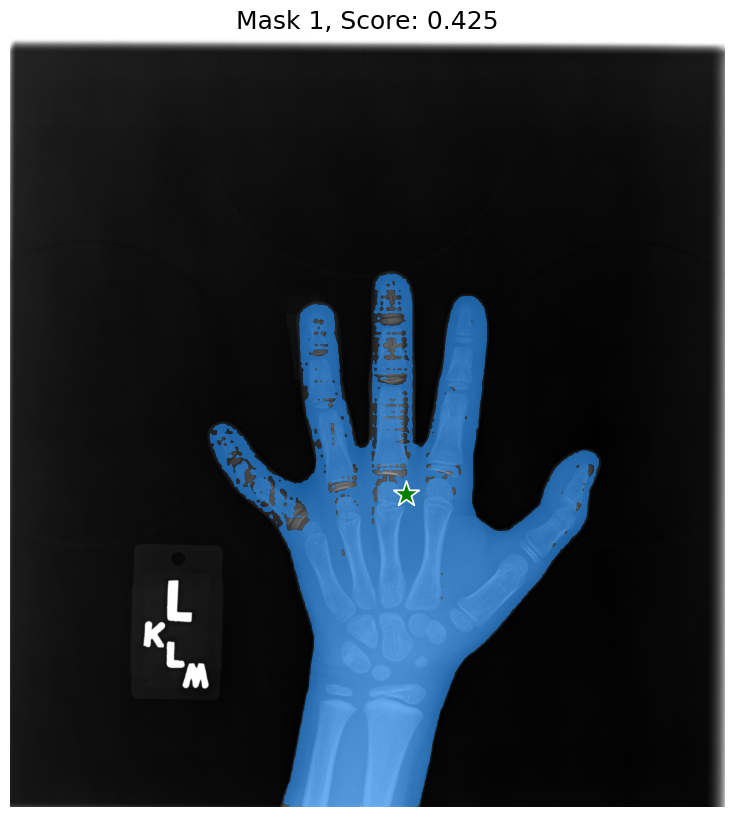

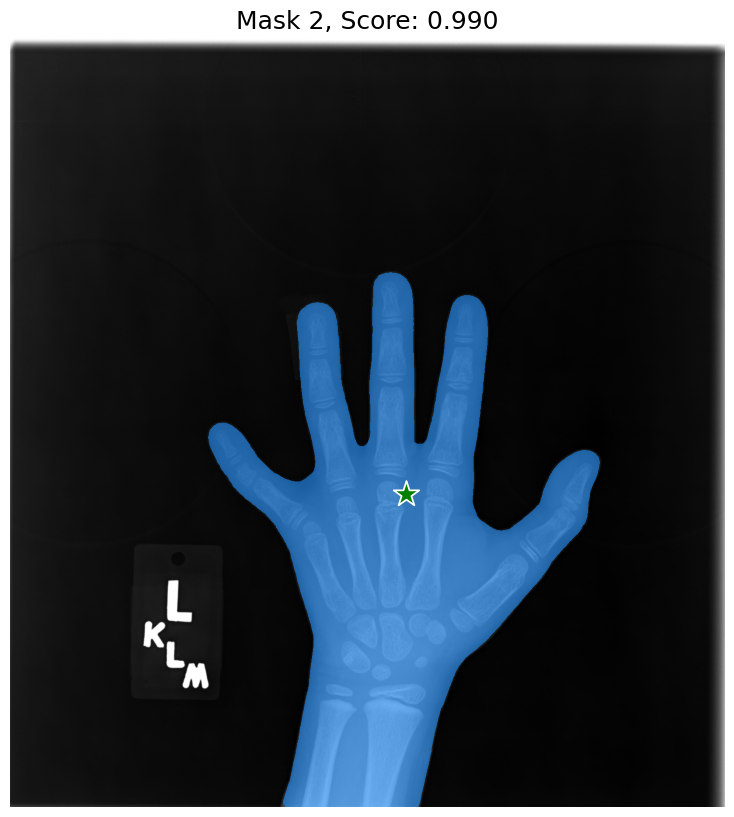

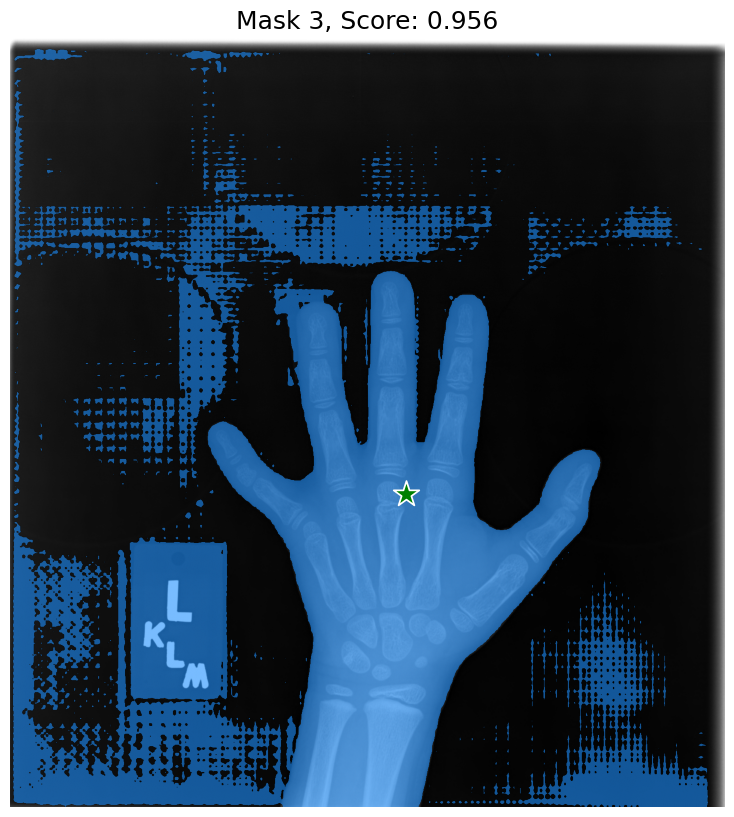

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


## Fancy things with masks

In [ ]:
sums = np.sum(masks, axis=(1, 2))
# Find the index of the image with the highest sum
max_index = np.argmax(sums)
best_image = masks[max_index]

In [ ]:
margin = 25
binary_mask = best_image
# Find the coordinates of the bounding box
rows, cols = np.where(binary_mask == 1)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)

# Adjust the bounding box with the margin
min_row = max(0, min_row - margin)
max_row = min(binary_mask.shape[0] - 1, max_row + margin)
min_col = max(0, min_col - margin)
max_col = min(binary_mask.shape[1] - 1, max_col + margin)

# Crop the original image based on the adjusted bounding box
cropped_image = image[min_row:max_row+1, min_col:max_col+1]

In [ ]:
plt.imshow(cropped_image, cmap='Greys')